In [1]:
# Different gradient descent methods and learning rates NOT DONE
import matplotlib.pyplot as plt
from Functions import Adam_update, Heatmap_with_labels, NeuralNetwork, RMSprop_init, RMSprop_update, mse, der_mse, sigmoid, der_sigmoid, linear, der_linear, dataset, ReLU, der_ReLU, LeakyReLu, der_LeakyReLu, run_training_experiment
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from Functions import Adam_init
import time
import matplotlib.gridspec as gridspec
np.random.seed(42)
n_samples = 18
x, y_true, y_noise = dataset(n_samples)
scaler = StandardScaler()
X = scaler.fit_transform(x.reshape(-1, 1)) # Feature matrix (n_samples
y = y_noise - np.mean(y_noise)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Optimal Parameters for L_0

In [4]:
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

# 1. Define K-Fold parameters
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
epochs=100
cost_func=mse
cost_der_func=der_mse

# Grid search list
learning_rates = np.logspace(-4, 0, 5)
methods = ["RMSprop", "Adam"]
nodes = [10, 20, 50, 100]
Layers = [1, 2, 3]
activations_list = [(sigmoid,der_sigmoid), (ReLU, der_ReLU), (LeakyReLu, der_LeakyReLu)]
regularization_types = [None]
lambda_regs = [0.01] #np.logspace(-5, -1, 5)
batch_sizes = [3, 5, 10]

results = np.zeros((len(methods), len(learning_rates), len(nodes), len(Layers), len(activations_list), len(regularization_types), len(lambda_regs), len(batch_sizes)))

for i, method in tqdm(enumerate(methods), total=len(methods), desc="Grid Search Progress"):
    for j, learning_rate in tqdm(enumerate(learning_rates), total=len(learning_rates), desc="Learning Rate Progress",leave=False):
        for k, node in tqdm(enumerate(nodes), total=len(nodes), desc="Node Progress",leave=False):
            for l, layer in enumerate(Layers):
                for m, (activation, activation_der) in enumerate(activations_list):
                    for n, regularization_type in enumerate(regularization_types):
                        for o, lambda_reg in enumerate(lambda_regs):
                            for p, batch_size in enumerate(batch_sizes):
                                layer_sizes = [node] * layer + [1]
                                activation_funcs = [activation] * layer + [linear]
                                activation_der_funcs = [activation_der] * layer + [der_linear]
                                fold_scores = []
                                for train_index, test_index in kf.split(X_train):
                                    # Create the k-fold train/test splits
                                    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
                                    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

                                    best_fold_score, _, _ = run_training_experiment(X_train_fold,       y_train_fold, 
                                    X_test_fold, y_test_fold,
                                    n_epochs=epochs, method=method, batch_size=batch_size, learning_rate=learning_rate,
                                    activation_funcs=activation_funcs,
                                    activation_ders=activation_der_funcs,
                                    layer_sizes=layer_sizes,
                                    cost_func=cost_func,
                                    cost_der_func=cost_der_func, 
                                    Regularization_type=regularization_type, 
                                    lambda_reg=lambda_reg)
                                    fold_scores.append(best_fold_score)
                                results[i, j, k, l, m, n, o, p] = np.mean(fold_scores)

print("Grid Search completed.")

# 5. Find the best parameters and cost

best_indices = np.unravel_index(np.argmin(results, axis=None), results.shape)
best_cost = np.log10(results.min())

print(f"""--- Best Result (from {k_folds}-Fold CV) ---
Best Avg. Cost: {best_cost:.6f}
-------------------------
Method: {methods[best_indices[0]]}
Learning Rate: {learning_rates[best_indices[1]]}
Nodes: {nodes[best_indices[2]]}
Layers: {Layers[best_indices[3]]}
Activation: {activations_list[best_indices[4]][0].__name__}
Regularization: {regularization_types[best_indices[5]]}
Lambda: {lambda_regs[best_indices[6]]}
Batch Size: {batch_sizes[best_indices[7]]}
""")

Grid Search Progress:   0%|          | 0/2 [00:00<?, ?it/s]

Learning Rate Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Node Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Node Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Node Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Node Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Node Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Learning Rate Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Node Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Node Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Node Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Node Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Node Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Grid Search completed.
--- Best Result (from 5-Fold CV) ---
Best Avg. Cost: 0.003366
-------------------------
Method: RMSprop
Learning Rate: 0.1
Nodes: 10
Layers: 2
Activation: LeakyReLu
Regularization: None
Lambda: 0.01
Batch Size: 5



In [5]:
np.log10(results.min())

np.float64(-2.4729115138686693)

Final Test MSE with best parameters: 0.001444


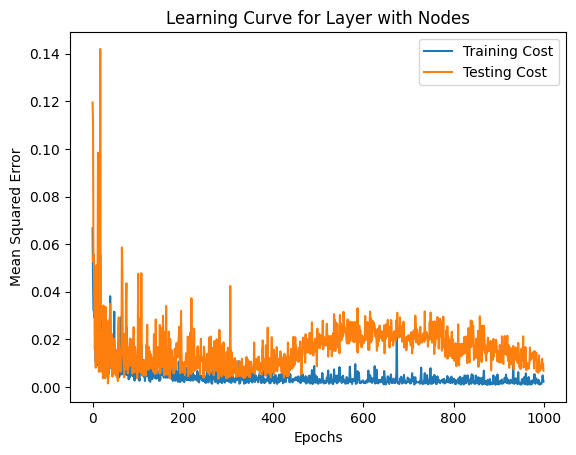

In [9]:
cost, training_scores, testing_scores = run_training_experiment(X_train, y_train, X_test, y_test,
                                    n_epochs=1000, method=methods[best_indices[0]], batch_size=batch_sizes[best_indices[7]], learning_rate=learning_rates[best_indices[1]],
                                    activation_funcs=[activations_list[best_indices[4]][0]] * Layers[best_indices[3]] + [linear],
                                    activation_ders=[activations_list[best_indices[4]][1]] * Layers[best_indices[3]] + [der_linear],
                                    layer_sizes=[nodes[best_indices[2]]] * Layers[best_indices[3]] + [1],
                                    cost_func=mse,
                                    cost_der_func=der_mse,)

print(f"Final Test MSE with best parameters: {cost:.6f}")
plt.plot(training_scores, label=f'Training Cost')
plt.plot(testing_scores, label=f'Testing Cost ')
plt.title(f'Learning Curve for Layer with Nodes')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

## Optimal Parameters for L1

In [6]:
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

# 1. Define K-Fold parameters
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
epochs=100
cost_func=mse
cost_der_func=der_mse

# Grid search list
learning_rates = np.logspace(-4, 0, 5)
methods = ["RMSprop", "Adam"]
nodes = [10, 20, 50, 100]
Layers = [1, 2, 3]
activations_list = [(sigmoid,der_sigmoid), (ReLU, der_ReLU), (LeakyReLu, der_LeakyReLu)]
regularization_types = ["L1"]
lambda_regs = np.logspace(-5, -1, 5)
batch_sizes = [3, 5, 10]

results = np.zeros((len(methods), len(learning_rates), len(nodes), len(Layers), len(activations_list), len(regularization_types), len(lambda_regs), len(batch_sizes)))

for i, method in tqdm(enumerate(methods), total=len(methods), desc="Grid Search Progress"):
    for j, learning_rate in tqdm(enumerate(learning_rates), total=len(learning_rates), desc="Learning Rate Progress",leave=False):
        for k, node in tqdm(enumerate(nodes), total=len(nodes), desc="Node Progress",leave=False):
            for l, layer in enumerate(Layers):
                for m, (activation, activation_der) in enumerate(activations_list):
                    for n, regularization_type in enumerate(regularization_types):
                        for o, lambda_reg in enumerate(lambda_regs):
                            for p, batch_size in enumerate(batch_sizes):
                                layer_sizes = [node] * layer + [1]
                                activation_funcs = [activation] * layer + [linear]
                                activation_der_funcs = [activation_der] * layer + [der_linear]
                                fold_scores = []
                                for train_index, test_index in kf.split(X_train):
                                    # Create the k-fold train/test splits
                                    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
                                    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

                                    best_fold_score, _, _ = run_training_experiment(X_train_fold,       y_train_fold, 
                                    X_test_fold, y_test_fold,
                                    n_epochs=epochs, method=method, batch_size=batch_size, learning_rate=learning_rate,
                                    activation_funcs=activation_funcs,
                                    activation_ders=activation_der_funcs,
                                    layer_sizes=layer_sizes,
                                    cost_func=cost_func,
                                    cost_der_func=cost_der_func, 
                                    Regularization_type=regularization_type, 
                                    lambda_reg=lambda_reg)
                                    fold_scores.append(best_fold_score)
                                results[i, j, k, l, m, n, o, p] = np.mean(fold_scores)

print("Grid Search completed.")

# 5. Find the best parameters and cost

best_indices = np.unravel_index(np.argmin(results, axis=None), results.shape)
best_cost = np.log10(results.min())

print(f"""--- Best Result (from {k_folds}-Fold CV) ---
Best Avg. Cost: {best_cost:.6f}
-------------------------
Method: {methods[best_indices[0]]}
Learning Rate: {learning_rates[best_indices[1]]}
Nodes: {nodes[best_indices[2]]}
Layers: {Layers[best_indices[3]]}
Activation: {activations_list[best_indices[4]][0].__name__}
Regularization: {regularization_types[best_indices[5]]}
Lambda: {lambda_regs[best_indices[6]]}
Batch Size: {batch_sizes[best_indices[7]]}

""")

Grid Search Progress:   0%|          | 0/2 [00:00<?, ?it/s]

Learning Rate Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Node Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Node Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Node Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Node Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Node Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Learning Rate Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Node Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Node Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Node Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Node Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Node Progress:   0%|          | 0/4 [00:00<?, ?it/s]

c:\Users\Anton\Documents\UiO Fag\FYS-STK4155 Anvendt dataanalyse og maskinlæring\Eget Arbeid\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)


Grid Search completed.
--- Best Result (from 5-Fold CV) ---
Best Avg. Cost: -2.444831
-------------------------
Method: RMSprop
Learning Rate: 0.1
Nodes: 20
Layers: 2
Activation: LeakyReLu
Regularization: L1
Lambda: 1e-05
Batch Size: 10



## Optimal Parameters for L2

In [2]:
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

# 1. Define K-Fold parameters
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
epochs=100
cost_func=mse
cost_der_func=der_mse

# Grid search list
learning_rates = np.logspace(-4, -1, 4)
methods = ["RMSprop", "Adam"]
nodes = [10, 20, 50, 100]
Layers = [1, 2, 3]
activations_list = [(sigmoid,der_sigmoid), (ReLU, der_ReLU), (LeakyReLu, der_LeakyReLu)]
regularization_types = ["L2"]
lambda_regs = np.logspace(-5, -1, 4)
batch_sizes = [3, 5, 10]

results = np.zeros((len(methods), len(learning_rates), len(nodes), len(Layers), len(activations_list), len(regularization_types), len(lambda_regs), len(batch_sizes)))

for i, method in tqdm(enumerate(methods), total=len(methods), desc="Grid Search Progress"):
    for j, learning_rate in tqdm(enumerate(learning_rates), total=len(learning_rates), desc="Learning Rate Progress",leave=False):
        for k, node in tqdm(enumerate(nodes), total=len(nodes), desc="Node Progress",leave=False):
            for l, layer in enumerate(Layers):
                for m, (activation, activation_der) in enumerate(activations_list):
                    for n, regularization_type in enumerate(regularization_types):
                        for o, lambda_reg in enumerate(lambda_regs):
                            for p, batch_size in enumerate(batch_sizes):
                                layer_sizes = [node] * layer + [1]
                                activation_funcs = [activation] * layer + [linear]
                                activation_der_funcs = [activation_der] * layer + [der_linear]
                                fold_scores = []
                                for train_index, test_index in kf.split(X_train):
                                    # Create the k-fold train/test splits
                                    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
                                    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

                                    best_fold_score, _, _ = run_training_experiment(X_train_fold,       y_train_fold, 
                                    X_test_fold, y_test_fold,
                                    n_epochs=epochs, method=method, batch_size=batch_size, learning_rate=learning_rate,
                                    activation_funcs=activation_funcs,
                                    activation_ders=activation_der_funcs,
                                    layer_sizes=layer_sizes,
                                    cost_func=cost_func,
                                    cost_der_func=cost_der_func, 
                                    Regularization_type=regularization_type, 
                                    lambda_reg=lambda_reg)
                                    fold_scores.append(best_fold_score)
                                results[i, j, k, l, m, n, o, p] = np.mean(fold_scores)

print("Grid Search completed.")

# 5. Find the best parameters and cost

best_indices = np.unravel_index(np.argmin(results, axis=None), results.shape)
best_cost = np.log10(results.min())

print(f"""--- Best Result (from {k_folds}-Fold CV) ---
Best Avg. Cost: {best_cost:.6f}
-------------------------
Method: {methods[best_indices[0]]}
Learning Rate: {learning_rates[best_indices[1]]}
Nodes: {nodes[best_indices[2]]}
Layers: {Layers[best_indices[3]]}
Activation: {activations_list[best_indices[4]][0].__name__}
Regularization: {regularization_types[best_indices[5]]}
Lambda: {lambda_regs[best_indices[6]]}
Batch Size: {batch_sizes[best_indices[7]]}
""")

Grid Search Progress:   0%|          | 0/2 [00:00<?, ?it/s]

Learning Rate Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Node Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Node Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Node Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Node Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Learning Rate Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Node Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Node Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Node Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Node Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Grid Search completed.
--- Best Result (from 5-Fold CV) ---
Best Avg. Cost: -2.491639
-------------------------
Method: RMSprop
Learning Rate: 0.1
Nodes: 10
Layers: 2
Activation: LeakyReLu
Regularization: L2
Lambda: 0.00021544346900318823
Batch Size: 3



# Image Classification Optimal Parameters

In [15]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder
#New Dataset
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
X = mnist.data / 255.0  # Normalize pixel values to [0, 1]
y = mnist.target
y = y.astype(int)
encoder = OneHotEncoder(sparse_output=False, categories='auto')
y_onehot = encoder.fit_transform(y.reshape(-1, 1))


X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, random_state=42, train_size=0.8, test_size=0.2)


In [16]:
X_train = X_train[:1000]
y_train = y_train[:1000]

In [17]:
from sklearn.model_selection import KFold
from Functions import softmax, der_softmax, cross_entropy
import time
from tqdm.notebook import tqdm

# 1. Define K-Fold parameters
k_folds = 5 
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
epochs=5
cost_func=cross_entropy
cost_der_func=der_softmax

# Grid search list
learning_rates = np.logspace(-4, -1, 4)
methods = ["RMSprop", "Adam"]
nodes = [20, 50, 75, 100]
Layers = [2, 3, 4]
activations_list = [(sigmoid,der_sigmoid), (ReLU, der_ReLU), (LeakyReLu, der_LeakyReLu)]
regularization_types = [None,"L1","L2"]
lambda_regs = np.logspace(-5, -1, 4)
batch_sizes = [16,32,64]

results = np.zeros((len(methods), len(learning_rates), len(nodes), len(Layers), len(activations_list), len(regularization_types), len(lambda_regs), len(batch_sizes)))

for i, method in tqdm(enumerate(methods), total=len(methods), desc="Grid Search Progress",position=0):
    for j, learning_rate in tqdm(enumerate(learning_rates), total=len(learning_rates), desc="Learning Rate Progress",position=1):
        for k, node in tqdm(enumerate(nodes), total=len(nodes), desc="Node Progress",position=2,leave=False):
            for l, layer in tqdm(enumerate(Layers), total=len(Layers), desc="Layer Progress",position=3,leave=False):
                for m, (activation, activation_der) in enumerate(activations_list):
                    for n, regularization_type in enumerate(regularization_types):
                        for o, lambda_reg in enumerate(lambda_regs):
                            for p, batch_size in enumerate(batch_sizes):
                                layer_sizes = [node] * layer + [10]
                                activation_funcs = [activation] * layer + [softmax]
                                activation_der_funcs = [activation_der] * layer + [der_softmax]
                                fold_scores = []
                                for train_index, test_index in kf.split(X_train):
                                    # Create the k-fold train/test splits
                                    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
                                    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

                                    best_fold_score, _, _ = run_training_experiment(X_train_fold,       y_train_fold, 
                                    X_test_fold, y_test_fold,
                                    n_epochs=epochs, method=method, batch_size=batch_size, learning_rate=learning_rate,
                                    activation_funcs=activation_funcs,
                                    activation_ders=activation_der_funcs,
                                    layer_sizes=layer_sizes,
                                    cost_func=cost_func,
                                    cost_der_func=cost_der_func, 
                                    Regularization_type=regularization_type, 
                                    lambda_reg=lambda_reg)
                                    fold_scores.append(best_fold_score)
                                results[i, j, k, l, m, n, o, p] = np.mean(fold_scores)


print("Grid Search completed.")

# 5. Find the best parameters and cost

best_indices = np.unravel_index(np.argmin(results, axis=None), results.shape)
best_cost = results.min()

print(f"""--- Best Result (from {k_folds}-Fold CV) ---
Best Avg. Cost: {best_cost:.6f}
-------------------------
Method: {methods[best_indices[0]]}
Learning Rate: {learning_rates[best_indices[1]]}
Nodes: {nodes[best_indices[2]]}
Layers: {Layers[best_indices[3]]}
Activation: {activations_list[best_indices[4]][0].__name__}
Regularization: {regularization_types[best_indices[5]]}
Lambda: {lambda_regs[best_indices[6]]}
Batch Size: {batch_sizes[best_indices[7]]}
""")

Grid Search Progress:   0%|          | 0/2 [00:00<?, ?it/s]

Learning Rate Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Node Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Layer Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Layer Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Layer Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Layer Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Node Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Layer Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Layer Progress:   0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\Anton\Documents\UiO Fag\FYS-STK4155 Anvendt dataanalyse og maskinlæring\Eget Arbeid\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
c:\Users\Anton\Documents\UiO Fag\FYS-STK4155 Anvendt dataanalyse og maskinlæring\Eget Arbeid\Project Work\Project 2\Code\Functions.py:74: RuntimeWarning: invalid value encountered in multiply
  sample_losses = np.sum(-target * np.log(predict), axis=1)


Layer Progress:   0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\Anton\Documents\UiO Fag\FYS-STK4155 Anvendt dataanalyse og maskinlæring\Eget Arbeid\Project Work\Project 2\Code\Functions.py:61: RuntimeWarning: invalid value encountered in divide
  return e_z / np.sum(e_z, axis=1)[:, np.newaxis]


Layer Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Node Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Layer Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Layer Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Layer Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Layer Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Node Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Layer Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Layer Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Layer Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Layer Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Learning Rate Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Node Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Layer Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Layer Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Layer Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Layer Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Node Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Layer Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Layer Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Layer Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Layer Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Node Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Layer Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Layer Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Layer Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Layer Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Node Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Layer Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Layer Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Layer Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Layer Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Grid Search completed.
--- Best Result (from 5-Fold CV) ---
Best Avg. Cost: 0.414869
-------------------------
Method: RMSprop
Learning Rate: 0.01
Nodes: 75
Layers: 2
Activation: sigmoid
Regularization: L2
Lambda: 1e-05
Batch Size: 32

